<a href="https://colab.research.google.com/github/pabair/rl-course-ws2020/blob/main/solutions/S4_PyTorch_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minimal PyTorch Example



This notebooks shows a very minimal example on how to use PyTorch for training a neural network on the Iris data set.

Note: This notebook is inspired by https://jamesmccaffrey.wordpress.com/2020/05/22/a-minimal-pytorch-complete-example/

### 0. Preamble

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

torch.manual_seed(1)
np.random.seed(1)

The following lines checks for GPU availability on the machine and sets the GPU as processing device (if available).
If you are on Colab you can enable GPU support in the menu via  "Runtime > Change runtime type" and select "GPU" as hardware accelerator.

In [ ]:
if(torch.cuda.is_available()):
  processing_chip = "cuda:0"
  print(f"{torch.cuda.get_device_name(0)} available")
else:
  processing_chip = "cpu"
  print("No GPU available")

device = torch.device(processing_chip)
device

No GPU available


device(type='cpu')

### 1. Data Preperation

For this small example we use the [Iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set). The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on these four features, we want to train a model that can predict the species.

In the first step we load the data into a Pandas.

In [ ]:
url = 'https://raw.githubusercontent.com/pabair/rl-course-ws2020/main/data/iris.csv'
dataset = pd.read_csv(url)
dataset.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


To be able to train a model, we first need to transform the *species* column into a numeric:

In [ ]:
dataset.loc[dataset.species=='Iris-setosa', 'species'] = 0
dataset.loc[dataset.species=='Iris-versicolor', 'species'] = 1
dataset.loc[dataset.species=='Iris-virginica', 'species'] = 2
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Next, we specify which columns we want to use as features and which as label:

In [ ]:
X = dataset[dataset.columns[0:4]].values
y = dataset.species.values.astype(int)

We then split our data into training and test data.

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)
print(train_X.shape, test_X.shape)

(120, 4) (30, 4)


To be able to use the data in PyTorch, we need to convert them into PyTorch tensors. Such a tensor can be thought of an efficient way to represent lists and matrices (similar to Numpy), with the additional benefit that they can be moved to the GPU (the `.to(device)` part in the code below) and that they support automatic backpropagation (more on this later):

In [ ]:
train_x = torch.Tensor(train_X).float().to(device)
test_x = torch.Tensor(test_X).float().to(device)
train_y =torch.Tensor(train_y).long().to(device)
test_y = torch.Tensor(test_y).long().to(device)

### 2. Model definition
We define now the strucutre of our neural network.
By convention we put in the `__init__` method the layers we want to use in the network and in the `forward` mehtod how data flows through this network.

Our network has 4 input features, 7 hidden layer nodes and 3 output neurons. The hidden layer uses a Relu activation function. Note that the output layer dos not have a softmax activation, but rather gives out a raw score for each class. 


In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.hidden1 = nn.Linear(4, 5)
    self.hidden2 = nn.Linear(5, 7)  
    self.output = nn.Linear(7, 3)

  def forward(self, x):
    z = F.relu(self.hidden1(x))
    z = F.relu(self.hidden2(z))
    z = self.output(z)  # no softmax. see CrossEntropyLoss() 
    return z

### 3. Model Training
We can now start traininging our network. We run several epochs in which we first predict on the training data with our network and than backpropagate the loss. For this we use PyTorch's build-in optimizer that runs gradient descent on the weights of the network. Hence, in every episode we reduce the loss on the training data and improve our network.

As loss function we use cross entropy, which consumes the raw scores from the prediction and internally applies a softmax (that is why we do not need the softmax as last layer in the network).

Note that all training data is passed at once to our network (line `net(train_x)`), since PyTorch will predict on all data points in parallel. 

In [ ]:
# create network, move it to device and set it to training-mode
net = Net().to(device)
net.train()

# define the parameters for training
no_epochs = 400
learning_rate = 0.04
loss_func = nn.CrossEntropyLoss()  # applies softmax() internally
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

print("\nStarting training ")

train_losses = []
for epoch in range(0, no_epochs):

  optimizer.zero_grad()
  output = net(train_x)

  loss = loss_func(output, train_y)
  loss.backward()
  optimizer.step()

  train_losses.append(loss.item())
  
  if epoch % 10 == 0:
    print(f"Loss in epoch {epoch} is {loss.item()}")

print("Done training ")


Starting training 
Loss in epoch 0 is 1.2527070045471191
Loss in epoch 10 is 1.0822917222976685
Loss in epoch 20 is 1.0675748586654663
Loss in epoch 30 is 1.0534247159957886
Loss in epoch 40 is 1.0361964702606201
Loss in epoch 50 is 1.0145955085754395
Loss in epoch 60 is 0.9876856207847595
Loss in epoch 70 is 0.9547569751739502
Loss in epoch 80 is 0.9154077172279358
Loss in epoch 90 is 0.868844747543335
Loss in epoch 100 is 0.8229727149009705
Loss in epoch 110 is 0.7832658290863037
Loss in epoch 120 is 0.7472976446151733
Loss in epoch 130 is 0.7155084013938904
Loss in epoch 140 is 0.6869000792503357
Loss in epoch 150 is 0.660788893699646
Loss in epoch 160 is 0.636789083480835
Loss in epoch 170 is 0.6147014498710632
Loss in epoch 180 is 0.5941784977912903
Loss in epoch 190 is 0.5752478837966919
Loss in epoch 200 is 0.5575352311134338
Loss in epoch 210 is 0.5408230423927307
Loss in epoch 220 is 0.5249208807945251
Loss in epoch 230 is 0.5096438527107239
Loss in epoch 240 is 0.49485114216

Text(0, 0.5, 'loss')

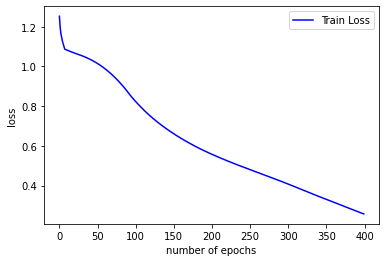

In [ ]:
  fig = plt.figure()
  plt.plot(range(0, no_epochs), train_losses, color='blue')
  plt.legend(['Train Loss'], loc='upper right')
  plt.xlabel('number of epochs')
  plt.ylabel('loss')

### 4. Model Evaluation
Finally, we check the model accuracy on the test data. For this we predict on the test data, identify the class with the highest score and compare it to the true label.

In [ ]:
net.eval() # set network to evaluation mode
y_pred = net(test_x)
_, predicted = torch.max(y_pred.data, 1)
correct = (predicted == test_y).sum().item()
print(f"Accuarcy is {100. * correct / len(test_x)}%")

Accuarcy is 96.66666666666667%


### 5. Solution Task 2
The change of the network layers and the increased number of epochs is directly done in the code above.

### 6. Solution Task 3

We first need to transform the features into a torch tensor:

In [ ]:
x = [4.9, 3.0, 1.4, 0.2]
torch_x = torch.Tensor(x).float().to(device)
torch_x.shape

torch.Size([4])

If we predict with the network on this tensor, we get raw scores but no probabilities:

In [ ]:
y_pred = net(torch_x)
y_pred

tensor([ 2.3505,  0.3262, -1.8010], grad_fn=<AddBackward0>)

Using the softmax function, we can normalize the scores to probabilites:

In [ ]:
 softmax = nn.Softmax(dim=0)
 softmax(y_pred)

tensor([0.8712, 0.1151, 0.0137], grad_fn=<SoftmaxBackward>)